# Preparation

## Packages and paths

In [7]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES
from GCTree_preparation import *
import warnings
import math
import matplotlib.image as mpimg
from PIL import Image

warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNSD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/HNSD_mini/outdir/sc_bulk_BCR_data_analysis_v0.1"

PROJECT = "220701_etc_biopsies"
path_to_main_output = f"{outdir}/tree_analysis/{PROJECT}"
path_to_02_output = os.path.join(path_to_main_output, "02_output")
os.system(f"mkdir -p {path_to_02_output}")

output_type = "custom_group_output"

path_to_trees = os.path.join(path_to_storage, PROJECT, "GCtrees/v0.2", output_type)

all_tree_folder = [item for item in pathlib.Path(path_to_trees).glob("*") if 
                   os.path.isfile(f"{str(item)}/02_dnapars/gctree.out.inference.1.nk") == True]

all_nk_files = [item for item in pathlib.Path(path_to_trees).glob("*/*/*gctree.out.inference.1.nk")]  
print(f"Number of trees: {len(all_tree_folder)}")   

path_to_metadata = "/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/220701_etc_biopsies/metadata.csv"
mid_metadata = pd.read_csv(path_to_metadata, sep =";")
path_to_04_output = os.path.join(outdir, "VDJ_output", "04_output")
thres = 0.85

all_clone_files = list(pathlib.Path(outdir).glob(f"VDJ_output/*/VDJ_output_{thres}/preprocessed_files/clonesets*.split_clones.xlsx"))

clonedf = pd.read_csv(os.path.join(path_to_04_output, "full_clonedf_with_mutation_rate.csv"), index_col= [0])
clonedf = clonedf[clonedf['num_mutation'] != "region_not_covered-skip"]
clonedf = clonedf[clonedf['dataset.name'] == "220701_etc_biopsies"]


Number of trees: 13481


## Load the tree data 

In [ ]:
#####------------------------------------------------------------------------#####
##### GENERATE TREE SUMMARY DATA FRAME
#####------------------------------------------------------------------------#####
rerun = False
if (os.path.isfile(f"{path_to_02_output}/tree_summarydf.csv") == False) or (rerun == True):
    saveTreeobj = dict()
    # loop through all trees
    maindf = pd.DataFrame()
    # for treedir in tqdm(all_tree_folder[0:1]):
    for treedir in tqdm(all_tree_folder):
        cloneid = treedir.name
        treedir = str(treedir)

        mouseID = cloneid.split("_")[0]
        group = "_".join(cloneid.split("_")[1:3]).replace("biopsy_YFP", "biopsy")
        V_gene = cloneid.split("_")[3]
        J_gene = cloneid.split("_")[4]
        CDR3_len = cloneid.split("_")[5]

        nk_path = f"{treedir}/02_dnapars/gctree.out.inference.1.nk"
        ab_dict_path = os.path.join(treedir, "01_deduplicate", f"{cloneid}.abundance.csv")
        path_to_orig_fasta= f"{treedir}/01_deduplicate/{cloneid}.aln.fasta"
        input_idmaps = f"{treedir}/01_deduplicate/{cloneid}.id_map_seq.csv"
    
        treeobj = GCtree(
            nk_path = nk_path,
            ab_dict_path = ab_dict_path,
            origin_fasta = path_to_orig_fasta,
            idmap_seq = input_idmaps
        )
        
        saveTreeobj[cloneid] = treeobj
        seqdf_orig = treeobj.seqdf
        seqs = treeobj.seqs
        num_nodes = len(treeobj.nodes)
        num_leaves = len(treeobj.leaves)
        num_internal_nodes = len(treeobj.internal_nodes)
        num_passthrough_nodes = len(treeobj.passthrough_nodes)
        num_split_nodes = len(treeobj.split_nodes)
        num_observed_nodes = len(treeobj.observed_nodes)
        num_inferred_nodes = len(treeobj.inferred_nodes)
        count_single_node = treeobj.count_single_node
        count_mix_node = treeobj.count_mix_node

        all_MIDs = seqdf_orig["MID"].unique()
        all_groups = [mid_metadata[mid_metadata["Unnamed: 0"] == item]["population"].unique()[0] for item in all_MIDs]
        tmpdf = pd.DataFrame(
            {
                "cloneid": cloneid,
                "mouseID": mouseID,
                "group": group,
                "V_gene": V_gene,
                "J_gene": J_gene,
                "CDR3_len": CDR3_len,
                "num_nodes": num_nodes,
                "num_leaves": num_leaves,
                "num_internal_nodes": num_internal_nodes,
                "num_passthrough_nodes": num_passthrough_nodes,
                "num_split_nodes": num_split_nodes,
                "num_observed_nodes": num_observed_nodes,
                "num_inferred_nodes": num_inferred_nodes,
                "num_MID": len(all_MIDs),
                "available_population": ",".join(all_groups),
                "num_seq_fasta": len(seqs),
                "num_single_node": count_single_node,
                "num_mix_node": count_mix_node
            },
            index=[0],
        )
        maindf = pd.concat([maindf, tmpdf], axis = 0)
    maindf = maindf.sort_values(by = "num_MID", ascending = False)

    maindf.to_csv(f"{path_to_02_output}/tree_summarydf.csv", index = False)
else:
    maindf = pd.read_csv(f"{path_to_02_output}/tree_summarydf.csv")

100%|██████████| 13481/13481 [04:54<00:00, 45.79it/s]


## Visualize some trees

In [28]:
cloneid = "m12_all_YFP_IGHV1-18-01_IGHJ3-01_36_2"
color_path = "./hex_color.csv"
mouseid = cloneid.split("_")[0]
group = "_".join(cloneid.split("_")[1:3]).replace("biopsy_YFP", "biopsy")
path_to_save_tree_svg = os.path.join(path_to_02_output, mouseid, group)
os.system(f"mkdir -p {path_to_save_tree_svg}")

treeobj = saveTreeobj[cloneid] 
avai_mids = treeobj.seqdf["MID"].unique()
mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

ts = treeobj.generate_tree_style(color_path = color_path)
treeobj.tree.render("%%inline", tree_style=ts) 

treeobj.tree.render(f"{path_to_save_tree_svg}/{cloneid}.png", tree_style=ts) 

{'nodes': [[675.8698920536183,
   232.35608715737374,
   679.8698920536183,
   236.35608715737374,
   0,
   None],
  [675.8698920536183,
   289.35608715737374,
   679.8698920536183,
   293.35608715737374,
   1,
   None],
  [548.3481309647927,
   304.35608715737374,
   552.3481309647927,
   308.35608715737374,
   4,
   None],
  [708.4717385746441,
   309.35608715737374,
   712.4717385746441,
   313.35608715737374,
   5,
   None],
  [668.2889059502724,
   316.35608715737374,
   672.2889059502724,
   320.35608715737374,
   7,
   None],
  [627.6044285522157,
   323.35608715737374,
   631.6044285522157,
   327.35608715737374,
   9,
   None],
  [585.9166616067891,
   328.35608715737374,
   589.9166616067891,
   332.35608715737374,
   11,
   None],
  [388.22452335494125,
   309.35608715737374,
   392.22452335494125,
   313.35608715737374,
   19,
   None],
  [443.8754047029886,
   316.35608715737374,
   447.8754047029886,
   320.35608715737374,
   20,
   None],
  [454.69647251485407,
   323.35

TypeError: Image data of dtype object cannot be converted to float

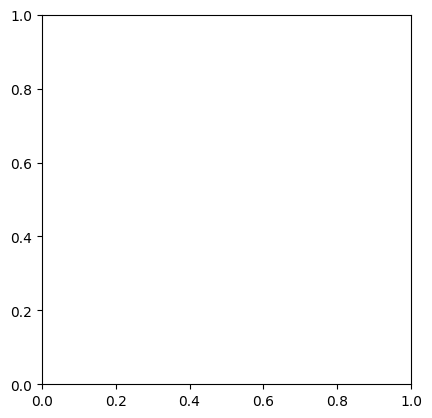

In [25]:
from PIL import Image
import io

 ##### Add legend
# img = mpimg.imread(f"{path_to_save_tree_svg}/{cloneid}.png")

# Create a figure
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')  # Hide axes

# Add legend manually
legend_labels = avai_mids
legend_colors = [mid_color_pal[mid] for mid in avai_mids]

# Create legend patches
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=patches, loc='lower right')

# Save the final image
plt.savefig(f"{path_to_save_tree_svg}/{cloneid}.addedLegend.svg", bbox_inches='tight', pad_inches=0.1, dpi=300, format="svg")
# plt.show()

# Main analysis

In [4]:
# maindf_mixtree = maindf[(maindf['num_mix_node'] > 0)]
# maindf_mixtree.available_population.unique()

In [5]:
# mouseid = "m11"
# yfp_case = "all"

# path_to_tree_fasta = f"{outdir}/VDJ_output/05_output/220701_etc_biopsies/FASTA/{mouseid}/{yfp_case}"
# mouse_mids = mid_metadata[mid_metadata["mouse"] == mouseid]["Unnamed: 0"].unique()

# ##### list of biopsy samples from the given mouse, MID
# biopsy_samples = mid_metadata[(mid_metadata["mouse"] == mouseid) & (mid_metadata["population"] == "biopsy")]["Unnamed: 0"].unique()

# ##### summary information of all trees obtained from the given mouse
# tree_mousedf = maindf[maindf["mouseID"] == mouseid]

# ##### list of all clones from all samples of the given mouse
# clone_mousedf = clonedf[clonedf["id"].isin(mouse_mids)]    

# ##### list of all clones from the biopsy sample of the given mouse
# other_clone_mousedf = clone_mousedf[clone_mousedf["id"].isin(biopsy_samples) == False]
# biopsy_clone_mousedf = clone_mousedf[clone_mousedf["id"].isin(biopsy_samples)]

# tree_mousedf.group.unique()
